# UV-Guider alignement with source in autocoll
##  Field 1

In [1]:
cd ../..

/Users/Vincent/Github/FireBallPipe


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from Calibration.mapping import Mapping

## initialization from last xy calib

In [57]:
G2UV = Guider2UV(filename='Notebook/2018/data_needed_to_run_notebooks/F1_180826.pkl')
print(G2UV)

FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    [(0.17436856, 0.00516991)]>
FOV center pixel position in guider [array([1330.61038367]), array([560.93947921])]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: 83.96815071133501 

In [58]:
target_filename = 'Calibration/Targets/2022/targets_F1.txt'
F1 = Table.read(target_filename, format='ascii')

## Diffuse UV image

load new mapping

In [59]:
mask_det_map_file = 'Notebook/2018/data_needed_to_run_notebooks/mapping-mask-det-180612-F1.pkl'
mask_det_map = Mapping(mask_det_map_file)
G2UV.set_detector_mapping(mask_det_map, offsets = [1., 1.])


## Scan sequence

GC - 46 - 51 - 14 - 8 - 12 - 16 - 38 - 44

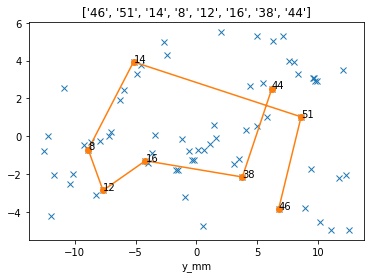

Internal-count,x_mm,y_mm,ra,dec,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
46,6.7589561,-3.858979,32.350896,-5.779373,-158.35059581807621,-416.94479999999993,446.0021047517373
51,8.6160157,1.0303866,32.395107,-5.663555,1175.38347272062,-247.3811999999981,1201.1343663629907
14,-5.1696728,3.934102,32.06701,-5.594838,318.3004184522386,394.60679999999826,506.9809493394291
8,-8.8972191,-0.6960435,31.97817,-5.704451,-103.92956391966716,184.38480000000155,211.6579994414876
12,-7.6793793,-2.8581218,32.007183,-5.755669,-297.8129982194271,-133.8768000000016,326.52041205211793
16,-4.190085,-1.2881544,32.090328,-5.718481,-679.4032276648445,73.12320000000199,683.326970153856
38,3.7831595,-2.1462593,32.279995,-5.738793,-203.77037807987836,-398.3760000000007,447.4659812307715
44,6.2134041,2.5275849,32.336883,-5.628133,0.0,0.0,0.0
44,6.2134041,2.5275849,32.336883,-5.628133,203.80954947898192,398.3760000000007,447.4838207520202


In [60]:

slits = ['46', '51', '14', '8', '12', '16', '38', '44'] 

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

ra,dec = "ra", "dec"

plt.figure()
plt.plot(F1["x_mm"],F1["y_mm"],"x")
plt.plot(selected_slits["x_mm"],selected_slits["y_mm"],"-o")
for s in selected_slits:
    plt.text(s["x_mm"],s["y_mm"],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title(slits)
plt.show()

selected_slits = selected_slits['Internal-count',"x_mm","y_mm",ra,dec]
slit_path = vstack((selected_slits,selected_slits[::-1]) )
# slit_path["ra_diff"] = [0] + list((slit_path[ra][1:] - slit_path[ra][:-1])*np.cos(slit_path[dec][:-1]*np.pi/180)) 
# slit_path["dec_diff"] = [0] + list((slit_path[dec][1:] - slit_path[dec][:-1])) 
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

# selected_slits

In [61]:



moves, flags, slits_coord = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = True)

print(moves,flags)
moves_tab = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
print(moves_tab)
assert moves.sum(axis=0)[0] <0.1
assert moves.sum(axis=0)[1] <0.1
# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves_tab["UV_image"] = moves_tab["UV_image"].astype(bool)
try:
    moves_tab.to_clipboard()
except Exception:
    pass
moves_tab 
# print(slit_path.to_pandas(), moves_tab[moves_tab["UV_image"]])
from astropy.table import hstack
# print(len(slit_path),len(moves_tab[moves_tab["UV_image"]]))
print(hstack((slit_path, Table.from_pandas(moves_tab[moves_tab["UV_image"]][2:]))))

# pd.concat([slit_path.to_pandas(), moves_tab[moves_tab["UV_image"]][2:]], axis=1)
# hstack((slit_path,moves_tab[moves_tab["UV_image"]]))

slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit position in mm on mask: [8.6160157 1.0303866]
slit position in mm on mask: [-5.1696728  3.934102 ]
slit position in mm on mask: [-8.8972191 -0.6960435]
slit position in mm on mask: [-7.6793793 -2.8581218]
slit position in mm on mask: [-4.190085  -1.2881544]
slit position in mm on mask: [ 3.7831595 -2.1462593]
slit position in mm on mask: [6.2134041 2.5275849]

targets local coords in siderostat local frame:
EL: 155.8 arcsec ; CE: 274.8 arcsec
EL: 365.4 arcsec ; CE: 346.9 arcsec
EL: 474.4 arcsec ; CE: -227.1 arcsec
EL: 273.9 arcsec ; CE: -377.0 arcsec
EL: 183.3 arcsec ; CE: -324.2 arcsec
EL: 253.7 arcsec ; CE: -181.2 arcsec
EL: 225.5 arcsec ; CE: 149.7 arcsec
EL: 426.4 arcsec ; CE: 245.7 arcsec

siderostat moves sequence: 
[[   0.          -30.        ]
 [  -0.           30.        ]
 [ 155.79863822  274.80731595]
 [ 209.5897664    72.04872165]
 [ 108.96407364 -573.93587185]
 [-200.47576394 -149.87035271]
 [ -90.56193597   52.702

observed slits position :

In [45]:
slits_coord_obs_det = np.array([
       [1965.59756538,  420.22242579],
       [1631.74361865,  289.23423754],
       [1467.73408468, 1349.36778046],
       [1784.27150004, 1626.79774278],
       [1927.70920124, 1532.48181218],
       [1818.74748265, 1266.98195373],
       [1859.64545293,  654.1904897 ],
       [1539.18268865,  478.63015312],
#retour
       [1538.98978056,  473.42365165],
       [1859.70918054,  650.33623459],
       [1819.23982594, 1263.17030059],
       [1927.97229623, 1527.29654425],
       [1784.71779993, 1630.64211506],
       [1468.24324699, 1354.89013602],
       [1631.89394058,  287.11784832],
       [1966.20476903,  416.24326822]])

# slits_coord_obs_det
slit_path["x_det_obs"] = slits_coord_obs_det[:,0]
slit_path["y_det_obs"] = slits_coord_obs_det[:,1]
slit_path


Internal-count,x_mm,y_mm,ra,dec,ra_diff,dec_diff,angular_distance,x_det_obs,y_det_obs
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64
46,6.7589561,-3.858979,32.350896,-5.779373,-158.35059581807621,-416.94479999999993,446.0021047517373,1965.59756538,420.22242579
51,8.6160157,1.0303866,32.395107,-5.663555,1175.38347272062,-247.3811999999981,1201.1343663629907,1631.74361865,289.23423754
14,-5.1696728,3.934102,32.06701,-5.594838,318.3004184522386,394.60679999999826,506.9809493394291,1467.73408468,1349.36778046
8,-8.8972191,-0.6960435,31.97817,-5.704451,-103.92956391966716,184.38480000000155,211.6579994414876,1784.27150004,1626.79774278
12,-7.6793793,-2.8581218,32.007183,-5.755669,-297.8129982194271,-133.8768000000016,326.52041205211793,1927.70920124,1532.48181218
16,-4.190085,-1.2881544,32.090328,-5.718481,-679.4032276648445,73.12320000000199,683.326970153856,1818.74748265,1266.98195373
38,3.7831595,-2.1462593,32.279995,-5.738793,-203.77037807987836,-398.3760000000007,447.4659812307715,1859.64545293,654.1904897
44,6.2134041,2.5275849,32.336883,-5.628133,0.0,0.0,0.0,1539.18268865,478.63015312
44,6.2134041,2.5275849,32.336883,-5.628133,203.80954947898192,398.3760000000007,447.4838207520202,1538.98978056,473.42365165


NameError: name 'Field' is not defined

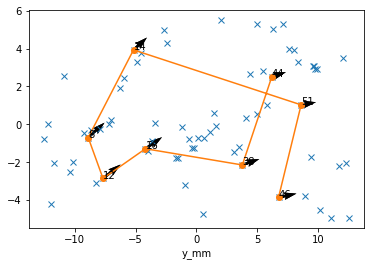

In [46]:
# TODO create some quiver of the error
plt.figure()
plt.plot(F1["x_mm"],F1["y_mm"],"x")
plt.plot(selected_slits["x_mm"],selected_slits["y_mm"],"-o")
for s in selected_slits:
    plt.text(s["x_mm"],s["y_mm"],s["Internal-count"])
plt.quiver(slit_path["x_mm"],slit_path["y_mm"],slit_path["x_det_obs"],slit_path["y_det_obs"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title(Field + " : %s"%(slits))
plt.show()

In [ ]:
valid = np.isfinite(slits_coord_obs_det[:,0])
#valid = np.array([True]*8 + [False]*8)
obs_wave = G2UV.mask_det_map.w[0]
print("wave: ", obs_wave)

slits_coord_valid = [slits_coord[i] for i in np.nonzero(valid)[0]]
slits_valid = np.array(slits + slits[::-1])[valid]

wave:  0.20255


In [ ]:
mid  = len(slits_coord_obs_det)//2
pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
pair_diff
plt.figure()
plt.subplot('120')
plt.plot(pair_diff[:,0],'*')
plt.plot(np.abs(pair_diff[:,0]),'-')
plt.title("El pair diff")
plt.ylabel("El arcsec")
plt.subplot('121')
plt.plot(pair_diff[:,1],'*')
plt.plot(np.abs(pair_diff[:,1]),'-')
plt.title("Ce pair diff")
plt.ylabel("Ce arcsec")


ValueError: Single argument to subplot must be a three-digit integer, not '120'

<Figure size 432x288 with 0 Axes>

In [ ]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )


Fitting rotation, translation and magnification
gamma: 1.0006108790418187
theta: -39.644068270865695 arcmin
dx: 1.1024747750345638 arcsec
dy: 4.984655023227374 arcsec
variances: [4.11192686e-04 1.41357633e+00 3.49021087e-01 3.49021087e-01]

residuals in arcsec: [[ 1.17318472  0.54579993]
 [-0.01797802  1.82609321]
 [ 1.46175773 -5.01449536]
 [ 0.68420164 -2.2945999 ]
 [-0.25537615  4.34532807]
 [-1.11057397  2.24512917]
 [ 0.08082209  2.43193811]
 [-0.45225052  4.16929747]
 [-0.26025613 -1.60154367]
 [ 0.01032764 -1.86938962]
 [-1.68968467 -1.98105369]
 [-0.50696513 -1.39368167]
 [ 0.02409439  1.96014729]
 [ 0.720119    1.10974138]
 [-0.24087447 -0.53630279]
 [ 0.37945184 -3.94240794]]
max residual in EL,CE 1.7, 5.0 arcsec
mean residual in EL,CE 0.8, 2.7 arcsec


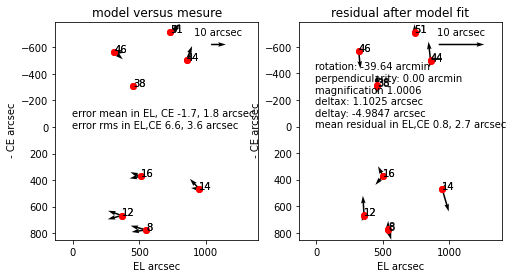

In [47]:
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)

G2UVcor = G2UV.update_model(slits_coord_valid, slits_coord_obs, labels=slits_valid, plot=True)[0]

In [48]:
#G2UVcor.save(filename=cloudpath + 'TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/F1_180904.pkl')

In [53]:
CEg, Elg = 1.02928, 1.00379


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = True, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))


moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]
moves["UV_image"] = moves["UV_image"].astype(bool)
new_cat = hstack((slit_path,moves[moves["UV_image"]][1:-1]))
new_cat
new_cat["EL_moves"] =  list(new_cat["EL_abs"][1:] - new_cat["EL_abs"][:-1]) +  [0]
new_cat["CE_moves"] =  list(new_cat["CE_abs"][1:] - new_cat["CE_abs"][:-1]) +  [0]



new_cat["El_sky"] = new_cat["EL_moves"]  * 2 * Elg 
new_cat["Cel_sky"] = new_cat["CE_moves"] * 2 * CEg 
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
new_cat.to_pandas().to_clipboard()
new_cat["ra_diff","dec_diff","EL_moves","CE_moves","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]

# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# moves.to_clipboard()
# moves

# from astropy.table import hstack 
# # Table.from_pandas(a[moves_tab["UV_image"]])[2:]
# print(moves_tab[moves_tab["UV_image"]],len(moves_tab[moves_tab["UV_image"]]))

# new_cat = hstack((slit_path,Table.from_pandas(moves_tab[moves_tab["UV_image"]])[2:]))
# print(Elg,CEg)
# new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg 
# new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg 
# new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
# new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
# new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
# new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# # new_cat
# new_cat.to_pandas().to_clipboard()
# new_cat

slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit position in mm on mask: [8.6160157 1.0303866]
slit position in mm on mask: [-5.1696728  3.934102 ]
slit position in mm on mask: [-8.8972191 -0.6960435]
slit position in mm on mask: [-7.6793793 -2.8581218]
slit position in mm on mask: [-4.190085  -1.2881544]
slit position in mm on mask: [ 3.7831595 -2.1462593]
slit position in mm on mask: [6.2134041 2.5275849]

targets local coords in siderostat local frame:
EL: 153.2 arcsec ; CE: 274.2 arcsec
EL: 362.0 arcsec ; CE: 348.7 arcsec
EL: 477.8 arcsec ; CE: -224.2 arcsec
EL: 279.1 arcsec ; CE: -376.4 arcsec
EL: 187.8 arcsec ; CE: -324.7 arcsec
EL: 256.5 arcsec ; CE: -180.8 arcsec
EL: 224.4 arcsec ; CE: 149.9 arcsec
EL: 424.3 arcsec ; CE: 248.1 arcsec

siderostat moves sequence: 


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_30218/2957200328.py:21: RuntimeWarning: invalid value encountered in true_divide
  new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_30218/2957200328.py:22: RuntimeWarning: invalid value encountered in true_divide
  new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_30218/2957200328.py:23: RuntimeWarning: invalid value encountered in true_divide
  new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]


ra_diff,dec_diff,EL_moves,CE_moves,El_sky,Cel_sky,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
float64,float64,float64,float64,float64,float64,float64,float64,float64
-158.35059581807621,-416.94479999999993,208.80678756487114,74.42960498154326,419.19633057948397,153.2178076308057,1.000712057283903,-1.0054000687368785,-0.9675859243803073
1175.38347272062,-247.3811999999981,115.78673732422465,-572.899341335197,232.4511381173669,-1179.3476680989831,1.0007520053310848,-0.9396475484691993,-1.0033726825928455
318.3004184522386,394.60679999999826,-198.76954385674884,-152.17435387478088,-399.0457608559318,-313.26003791246893,1.000660576348983,-1.011249073396438,-0.984164706523859
-103.92956391966716,184.38480000000155,-91.21495673743885,51.701376817820346,-183.1213228469475,106.43038626209226,1.0006888085503678,-0.9931476067818278,-1.0240626655987715
-297.8129982194271,-133.8768000000016,68.67709840673314,143.90893527232186,137.8747692193893,296.24517779419085,1.0007270115514861,-1.0298630473643502,-0.9947355540738317
-679.4032276648445,73.12320000000199,-32.076994595431245,330.69188505654813,-64.39713280989585,680.7490869020077,1.000674984895498,-0.8806662291843642,-1.0019809432489584
-203.77037807987836,-398.3760000000007,199.86945810288535,98.25956174971964,401.2539266981905,202.27320343550286,1.004219718183638,-1.007224146781407,-0.9926526384331064
0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
203.80954947898192,398.3760000000007,-199.86945810288537,-98.25956174971964,-401.2539266981906,-202.27320343550286,1.0041796836658072,-1.0072241467814071,-0.9924618544744024


## Star sequence

gc - s8 - s25 - s31

In [21]:
star_target_path = cloudpath + 'Target_selection/GuidingStars/'

F1_stars = Table.read(star_target_path + "F1_guidingstars.fits", format='fits')

stars = [8, 25, 31]

star_movs, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = True)


star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(32.1014, -5.786504)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(32.221491, -5.776507)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(32.254526, -5.815258)]>

targets local coords in siderostat local frame:
EL: 134.8 arcsec ; CE: -159.9 arcsec
EL: 155.5 arcsec ; CE: 48.8 arcsec
EL: 86.8 arcsec ; CE: 107.2 arcsec

siderostat moves sequence: 
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: False
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: True
EL: 134.8 arcsec ; CE -159.9 arcsec ; image: True
EL: 20.7 arcsec ; CE 208.7 arcsec ; image: True
EL: -68.7 arcsec ; CE 58.3 arcsec ; image: True
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: False
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: True
EL: 68.7 arcsec ; CE -58.3 arcsec ; image: True
EL: -20.7 arcsec ; CE -238.7 arcsec ; image: False
EL: 0.0 arcsec ; CE 30.0 arcsec ; image: True
EL: -134.8 arcsec ; CE 159.9 arcsec ; image: True


In [22]:
stars_coord

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.07519354, 0.09142528)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.08673703, -0.02792538)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.04840695, -0.06128789)]>]

------------------------------------------------------

Re-compute model (thermal drift) ?

In [24]:
slits_coord_obs_det2 = np.array([
       [1967.77672211,  420.883372  ],
       [1634.94667484,  284.99941421],
       [1460.30889342, 1343.63228178],
       [1774.05043782, 1625.66456504],
       [1918.36655798, 1531.24794446],
       [1811.96613007, 1264.73988401],
       [1858.73062442,  652.77625595],
       [1539.37281284,  472.87952084],
#retour
       [1538.92830776,  467.65309777],
       [1858.32109489,  647.99384259],
       [1811.64481037, 1260.92668703],
       [1917.94530091, 1526.91879826],
       [1773.67417428, 1628.30043431],
       [1459.76904708, 1347.27853125],
       [1634.04334215,  281.33418915],
       [1966.71028008,  414.34595604]])
    
slits_coord_obs_det2

array([[1967.77672211,  420.883372  ],
       [1634.94667484,  284.99941421],
       [1460.30889342, 1343.63228178],
       [1774.05043782, 1625.66456504],
       [1918.36655798, 1531.24794446],
       [1811.96613007, 1264.73988401],
       [1858.73062442,  652.77625595],
       [1539.37281284,  472.87952084],
       [1538.92830776,  467.65309777],
       [1858.32109489,  647.99384259],
       [1811.64481037, 1260.92668703],
       [1917.94530091, 1526.91879826],
       [1773.67417428, 1628.30043431],
       [1459.76904708, 1347.27853125],
       [1634.04334215,  281.33418915],
       [1966.71028008,  414.34595604]])

In [25]:
valid = np.isfinite(slits_coord_obs_det2[:,0])
#valid = np.array([True]*8 + [False]*8)
obs_wave = G2UV.mask_det_map.w[0]
print("wave: ", obs_wave)

#slits_coord_valid = [slits_coord[i] for i in np.nonzero(valid)[0]]
#slits_valid = np.array(slits + slits[::-1])[valid]

wave:  0.20255


Text(0,0.5,'Ce arcsec')

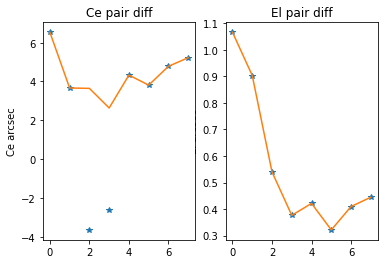

In [26]:
mid  = len(slits_coord_obs_det2)//2
pair_diff2 = slits_coord_obs_det2[:mid] - slits_coord_obs_det2[::-1][:mid]
pair_diff2
plt.figure()
plt.subplot('120')
plt.plot(pair_diff2[:,0],'*')
plt.plot(np.abs(pair_diff2[:,0]),'-')
plt.title("El pair diff")
plt.ylabel("El arcsec")
plt.subplot('121')
plt.plot(pair_diff2[:,1],'*')
plt.plot(np.abs(pair_diff2[:,1]),'-')
plt.title("Ce pair diff")
plt.ylabel("Ce arcsec")


In [30]:
valid2 = np.array([True]*16)
valid2[[0,1,-1,-2]] = False
slits2 = np.array(slits_valid)[valid2]
print(slits2)

['14' '8' '12' '16' '38' '44' '44' '38' '16' '12' '8' '14']


In [31]:
slits_coord_obs2 = G2UV.detector2guider(slits_coord_obs_det2[valid2], wave=obs_wave, angle=True  )
slits_coord_valid2 = [slits_coord[i] for i in np.nonzero(valid2)[0]]
slits_valid2 = np.array(slits + slits[::-1])[valid2]

Fitting rotation, translation and magnification
gamma: 1.0004019970657176
theta: 0.18488190877971084 arcmin
dx: -3.6320027044843672 arcsec
dy: 1.265077405430739 arcsec
variances: [5.47067103e-04 1.88067817e+00 4.63015102e-01 4.63015102e-01]

residuals in arcsec: [[ 6.30954183e-01 -4.05872365e+00]
 [-8.72259151e-03 -1.00583146e+00]
 [-8.73463106e-01  3.26606726e+00]
 [-1.52227671e+00  1.85935435e+00]
 [-5.07748091e-03  2.43003590e+00]
 [ 1.94836082e-01  4.10281673e+00]
 [ 7.04795287e-01 -1.69194866e+00]
 [ 5.30956249e-01 -2.91447063e+00]
 [-1.05544674e+00 -2.36908996e+00]
 [-2.65510735e-01 -1.53327703e+00]
 [ 4.14200160e-01  1.91556693e+00]
 [ 1.25475541e+00 -4.99766750e-04]]
max residual in EL,CE 1.5, 4.1 arcsec
mean residual in EL,CE 0.8, 2.5 arcsec


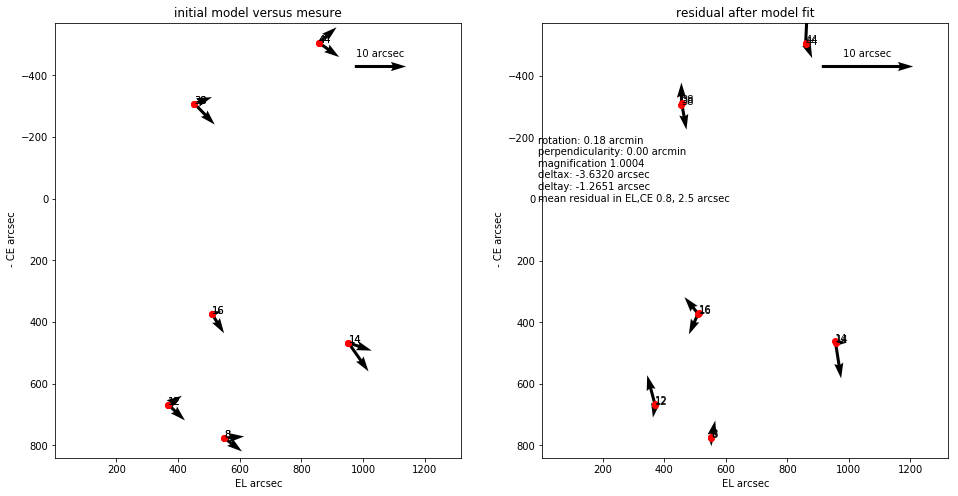

In [33]:
weight = np.array( [1.]*14  + [1./(1. + 1e-1)]*14)

G2UVcor2 = G2UV.update_model(slits_coord_valid2, slits_coord_obs2, labels=slits_valid2, plot=True)

In [34]:
star_movs2, stars_coord2 = G2UVcor2.compute_autocoll_move_stars(stars, F1_stars, hystcomp = True)


star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(32.1014, -5.786504)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(32.221491, -5.776507)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(32.254526, -5.815258)]>

targets local coords in siderostat local frame:
EL: 130.5 arcsec ; CE: -159.6 arcsec
EL: 153.7 arcsec ; CE: 48.9 arcsec
EL: 85.6 arcsec ; CE: 108.0 arcsec

siderostat moves sequence: 
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: False
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: True
EL: 130.5 arcsec ; CE -159.6 arcsec ; image: True
EL: 23.2 arcsec ; CE 208.5 arcsec ; image: True
EL: -68.1 arcsec ; CE 59.1 arcsec ; image: True
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: False
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: True
EL: 68.1 arcsec ; CE -59.1 arcsec ; image: True
EL: -23.2 arcsec ; CE -238.5 arcsec ; image: False
EL: 0.0 arcsec ; CE 30.0 arcsec ; image: True
EL: -130.5 arcsec ; CE 159.6 arcsec ; image: True


In [35]:
movs_new2, slits_coord_new2 = G2UVcor2.compute_autocoll_moves_slits(slits, F1, hystcomp = True)

slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit position in mm on mask: [8.6160157 1.0303866]
slit position in mm on mask: [-5.1696728  3.934102 ]
slit position in mm on mask: [-8.8972191 -0.6960435]
slit position in mm on mask: [-7.6793793 -2.8581218]
slit position in mm on mask: [-4.190085  -1.2881544]
slit position in mm on mask: [ 3.7831595 -2.1462593]
slit position in mm on mask: [6.2134041 2.5275849]

targets local coords in siderostat local frame:
EL: 154.1 arcsec ; CE: 274.3 arcsec
EL: 363.7 arcsec ; CE: 346.4 arcsec
EL: 472.7 arcsec ; CE: -227.8 arcsec
EL: 272.2 arcsec ; CE: -377.7 arcsec
EL: 181.6 arcsec ; CE: -325.0 arcsec
EL: 251.9 arcsec ; CE: -181.9 arcsec
EL: 223.8 arcsec ; CE: 149.2 arcsec
EL: 424.8 arcsec ; CE: 245.2 arcsec

siderostat moves sequence: 
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: False
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: True
EL: 154.1 arcsec ; CE 274.3 arcsec ; image: True
EL: 209.7 arcsec ; CE 72.1 arcsec ; image: True
EL: 109.0 arcsec ;